### I work through the PySpark tutorial from Datacamp by Karlijn Willems

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [35]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator


In [2]:
from pyspark.ml.linalg import DenseVector
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import RandomForestRegressor

In [3]:
spark = SparkSession.builder.master("local").appName("Linear Regression Model")\
        .getOrCreate()

In [4]:
sc = spark.sparkContext

### Load the California Housing dataset in the appropriate folder

In [5]:
rdd = sc.textFile("cal_housing\CaliforniaHousing\cal_housing.data")

In [6]:
header = sc.textFile("cal_housing\CaliforniaHousing\cal_housing.domain")
header.collect()

['longitude: continuous.',
 'latitude: continuous.',
 'housingMedianAge: continuous. ',
 'totalRooms: continuous. ',
 'totalBedrooms: continuous. ',
 'population: continuous. ',
 'households: continuous. ',
 'medianIncome: continuous. ',
 'medianHouseValue: continuous. ']

In [ ]:
rdd.take(5)
# Looking at the data below, we need to clean it. 

In [7]:
def clean_lines(my_rdd): 
    '''loads in a line of RDD and splits by comma'''
    return my_rdd.map(lambda line: line.split(","))
rdd = clean_lines(rdd)

In [8]:
rdd.take(2)

[['-122.230000',
  '37.880000',
  '41.000000',
  '880.000000',
  '129.000000',
  '322.000000',
  '126.000000',
  '8.325200',
  '452600.000000'],
 ['-122.220000',
  '37.860000',
  '21.000000',
  '7099.000000',
  '1106.000000',
  '2401.000000',
  '1138.000000',
  '8.301400',
  '358500.000000']]

#### Since RDDs are unweildy, we convert them to dataframes

In [9]:
# First get all the column names out as a list. Once you get a df, you can use df.columns; just wanted to experiment with 
# RDD manipulation
new_header = header.map(lambda line: line.split(':')).map(lambda x: x[0])
COLUMNS = new_header.collect()

In [10]:
from pyspark.sql import Row
df = rdd.map(lambda line: Row(longitude= line[0],
                             latitude = line[1],
                             housingMedianAge = line[2],
                             totalRooms = line[3],
                             totalBedRooms =line[4],
                             population = line[5],
                             households = line[6],
                             medianIncome = line[7],
                             medianHouseValue = line[8])).toDF()

In [11]:
df.show()

+-----------+----------------+---------+-----------+----------------+------------+-----------+-------------+-----------+
| households|housingMedianAge| latitude|  longitude|medianHouseValue|medianIncome| population|totalBedRooms| totalRooms|
+-----------+----------------+---------+-----------+----------------+------------+-----------+-------------+-----------+
| 126.000000|       41.000000|37.880000|-122.230000|   452600.000000|    8.325200| 322.000000|   129.000000| 880.000000|
|1138.000000|       21.000000|37.860000|-122.220000|   358500.000000|    8.301400|2401.000000|  1106.000000|7099.000000|
| 177.000000|       52.000000|37.850000|-122.240000|   352100.000000|    7.257400| 496.000000|   190.000000|1467.000000|
| 219.000000|       52.000000|37.850000|-122.250000|   341300.000000|    5.643100| 558.000000|   235.000000|1274.000000|
| 259.000000|       52.000000|37.850000|-122.250000|   342200.000000|    3.846200| 565.000000|   280.000000|1627.000000|
| 193.000000|       52.000000|37

In [12]:
df.printSchema()
# need to cast string types into float32 or int as needed

root
 |-- households: string (nullable = true)
 |-- housingMedianAge: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- medianHouseValue: string (nullable = true)
 |-- medianIncome: string (nullable = true)
 |-- population: string (nullable = true)
 |-- totalBedRooms: string (nullable = true)
 |-- totalRooms: string (nullable = true)



In [13]:
def cast_columns(df, names, newType):
    ''' cast the columns into type newType'''
    for name in names:
        df = df.withColumn(name, df[name].cast(newType))
    return df

In [14]:
df = cast_columns(df, COLUMNS, FloatType())

In [ ]:
# Get some summary statistics
df.describe().show()

# Data Exploration

#### It is obvious that certain variables are going to be correlated. For example look at the households and population columns

In [15]:
df.select('population', 'households').sort("population", ascending = False).show(10)

+----------+----------+
|population|households|
+----------+----------+
|   35682.0|    4769.0|
|   28566.0|    6082.0|
|   16305.0|    5358.0|
|   16122.0|    5189.0|
|   15507.0|    5050.0|
|   15037.0|    4072.0|
|   13251.0|    4339.0|
|   12873.0|    3931.0|
|   12427.0|    2826.0|
|   12203.0|    3701.0|
+----------+----------+
only showing top 10 rows



#### How correlated are the variables? 

In [16]:
# convert to vector column first - spark ml requires this before it can output correlations
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df.columns, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

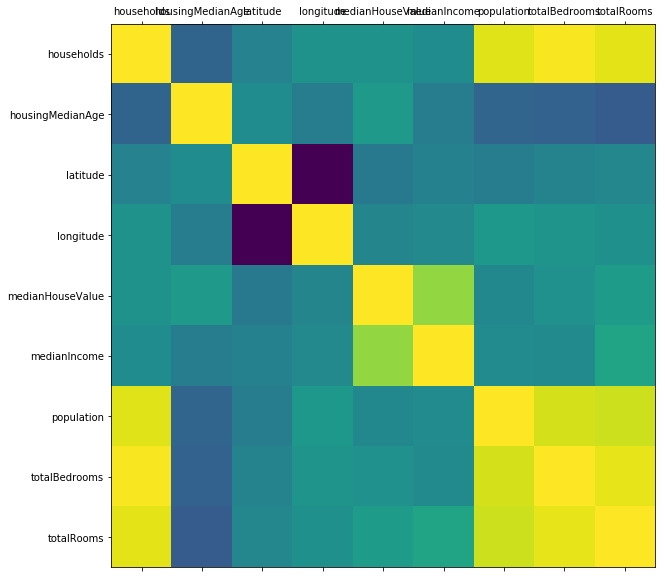

In [20]:
import matplotlib.pyplot as plt
import numpy as np
t = matrix.collect()[0]["pearson({})".format(vector_col)].values.reshape(9, 9)
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(t)
plt.xticks(range(len(df.columns)), df.columns)
plt.yticks(range(len(df.columns)), df.columns)
plt.show()

#### Median income is strongly correlateed with House value. Total bedrooms is correlated with total rooms which is clear. Also households is correlated wtih the population, which makes sense. Median house value is strongly correlated with income which is what we would expect. 

#### Given the presence of correlated features -- it may be useful to construct 3 new features: 
#### 1) Bedrooms/total rooms - as these basically have the same information. 
#### 2) population/Household
#### 3) Rooms/Household
#### We use these new features in our model

# Feature Engineering and Preprocessing

In [21]:
df = df.withColumn("bedroomsperhouse", col("totalBedrooms")/col("totalRooms")) \
                 .withColumn("roomsperhouse",col("totalRooms")/col("households"))\
                .withColumn("populationperhousehold", col("population")/col("households"))

In [22]:
# Next we also normalize the dependent variable to lie within reasonable values
df = df.withColumn("medianHouseValue", col("medianHouseValue")/100000)

In [ ]:
df.first()

In [ ]:
# Select the features to separate the indpeendent and dependent variables.
# Order the dataframe to have the dependent varialbe first followed by independent variables.

In [23]:
COLUMNS = ["medianHouseValue", "latitude", "longitude", "totalBedrooms", "totalRooms", "bedroomsperhouse", "roomsperhouse", "populationperhousehold",
           "households", "population"]

df = df.select(COLUMNS)

In [24]:
input_data = df.rdd.map(lambda x: (x[0], DenseVector(x[1:])))

df = spark.createDataFrame(input_data, ["label", "features"])
        

In [25]:
standardScaler = StandardScaler(inputCol = "features", outputCol = "features_scaled")
scaler= standardScaler.fit(df)
scaled_df = scaler.transform(df)

scaled_df.take(2)

[Row(label=4.526, features=DenseVector([37.88, -122.23, 129.0, 880.0, 0.1466, 6.9841, 2.5556, 126.0, 322.0]), features_scaled=DenseVector([17.7345, -61.0073, 0.3062, 0.4034, 2.5264, 2.8228, 0.2461, 0.3296, 0.2843])),
 Row(label=3.585, features=DenseVector([37.86, -122.22, 1106.0, 7099.0, 0.1558, 6.2381, 2.1098, 1138.0, 2401.0]), features_scaled=DenseVector([17.7251, -61.0023, 2.6255, 3.254, 2.6851, 2.5213, 0.2031, 2.9765, 2.1202]))]

# Modeling

In [26]:
train_data, test_data = scaled_df.randomSplit([0.8, 0.2], seed = 42)

In [27]:
lr = LinearRegression(labelCol = "label", featuresCol="features_scaled", maxIter = 10, regParam = 0.3, elasticNetParam = 0.8)
linear_model = lr.fit(train_data)

In [28]:
predicted = linear_model.transform(test_data)
predictions = predicted.select("prediction").rdd.map(lambda x: x[0])
labels = predicted.select("label").rdd.map(lambda x:x[0])

In [29]:
predictionAndLabel = predictions.zip(labels).collect()
predictionAndLabel[:5]

[(1.907724370590818, 0.14999),
 (1.999167360678562, 0.14999),
 (1.9996805078406774, 0.14999),
 (2.10058257432343, 0.283),
 (2.0456047117963516, 0.325)]

### Print the RMSE

In [36]:
print("The RMSE is {}".format(linear_model.summary.rootMeanSquaredError)) 

The RMSE is 1.1407430200686228


### This is not a good model as there are many correlated features. But the goal here is to work with Spark dataframes and not to get a great model. Let's try the random forest

In [37]:
rf = RandomForestRegressor(featuresCol = "features_scaled", labelCol="label")
rf_model = rf.fit(train_data)

In [38]:
training_error_rf = rf_model.transform(train_data)

In [39]:
predicted_rf = rf_model.transform(test_data)

In [40]:
predicted_rf.select("prediction", "label", "features").show(5)

+------------------+-------+--------------------+
|        prediction|  label|            features|
+------------------+-------+--------------------+
|1.5148258013341227|0.14999|[36.4000015258789...|
|1.1983996856743073|0.14999|[39.7099990844726...|
|1.1983996856743073|0.14999|[40.3100013732910...|
|1.7320269724372133|  0.283|[34.7000007629394...|
|1.6454804275394803|  0.325|[32.9300003051757...|
+------------------+-------+--------------------+
only showing top 5 rows



In [41]:
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")

In [42]:
training_error_rf.select("prediction", "label", "features").show(5)

+------------------+-------+--------------------+
|        prediction|  label|            features|
+------------------+-------+--------------------+
|1.7380528643855588|0.14999|[34.2400016784668...|
|2.5322295487349735|  0.175|[34.1500015258789...|
|1.4869021935586304|  0.225|[32.7099990844726...|
| 1.724755781812322|  0.225|[35.4300003051757...|
|1.7646717413681334|  0.225|[37.9300003051757...|
+------------------+-------+--------------------+
only showing top 5 rows



In [43]:
print("The Test RMSE is {}".format(evaluator.evaluate(predicted_rf)))
print("The Training RMSE is {}".format(evaluator.evaluate(training_error_rf)))

The Test RMSE is 0.8178782571955487
The Training RMSE is 0.8058457258962421


#### Grid Searching and Data Exploration is needed to make this model much more performant than what it is currently. But the RMSE is much lower than the Linear Regression. 